<a href="https://colab.research.google.com/github/danielbauer1979/ML_656/blob/main/SLC_HousePriceExample_inclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import graphviz
import pydot
from io import StringIO

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
import sklearn.metrics as metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# HOUSE PRICE EXAMPLE

# Get data

In [2]:
!git clone https://github.com/danielbauer1979/ML_656.git

Cloning into 'ML_656'...
remote: Enumerating objects: 340, done.
remote: Counting objects: 100% (223/223), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 340 (delta 124), reused 123 (delta 76), pack-reused 117
Receiving objects: 100% (340/340), 27.15 MiB | 9.26 MiB/s, done.
Resolving deltas: 100% (174/174), done.
Updating files: 100% (54/54), done.


In [3]:
house = pd.read_csv('ML_656/HouseData.csv')
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Prep Data

In [4]:
pd.set_option("display.max_rows", None)
house.isnull().sum(axis = 0)

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

In [5]:
house = house.drop(columns=['Id','LotFrontage','Alley', 'BsmtQual', 'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature'])

In [6]:
house = house.dropna()
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451 entries, 0 to 1459
Data columns (total 64 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1451 non-null   int64  
 1   MSZoning       1451 non-null   object 
 2   LotArea        1451 non-null   int64  
 3   Street         1451 non-null   object 
 4   LotShape       1451 non-null   object 
 5   LandContour    1451 non-null   object 
 6   Utilities      1451 non-null   object 
 7   LotConfig      1451 non-null   object 
 8   LandSlope      1451 non-null   object 
 9   Neighborhood   1451 non-null   object 
 10  Condition1     1451 non-null   object 
 11  Condition2     1451 non-null   object 
 12  BldgType       1451 non-null   object 
 13  HouseStyle     1451 non-null   object 
 14  OverallQual    1451 non-null   int64  
 15  OverallCond    1451 non-null   int64  
 16  YearBuilt      1451 non-null   int64  
 17  YearRemodAdd   1451 non-null   int64  
 18  RoofStyl

In [7]:
col_types = house.columns.to_series().groupby(house.dtypes).groups
numerics = list(house.select_dtypes(include=['int64']).columns)
factors = list(house.select_dtypes(include=['object']).columns)

In [8]:
house_numcols = house[numerics].drop(columns = ['SalePrice'])
house_faccols = house[factors]
dummies = pd.get_dummies(house_faccols, drop_first=True)
house_numcols_sc_0 = scale(house_numcols)
house_numcols_sc = pd.DataFrame(data=house_numcols_sc_0, columns = house_numcols.columns, index = dummies.index)
house_sc = pd.concat([house_numcols_sc, dummies], axis = 1)
house_sc = pd.concat([house_sc, house['SalePrice']], axis =1)
house_sc = house_sc.rename(columns={"SalePrice":"Y"})
house_sc.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Y
0,0.072441,-0.205996,0.656247,-0.520740,1.057250,0.883532,0.579345,-0.289621,-0.943764,-0.457576,...,0,0,0,1,0,0,0,1,0,208500
1,-0.872386,-0.090876,-0.067870,2.174601,0.162613,-0.424340,1.176868,-0.289621,-0.640635,0.469865,...,0,0,0,1,0,0,0,1,0,181500
2,0.072441,0.074297,0.656247,-0.520740,0.990980,0.835093,0.096054,-0.289621,-0.301312,-0.311378,...,0,0,0,1,0,0,0,1,0,223500
3,0.308648,-0.095881,0.656247,-0.520740,-1.858602,-0.714978,-0.497076,-0.289621,-0.061524,-0.686010,...,0,0,0,1,0,0,0,0,0,140000
4,0.072441,0.375612,1.380365,-0.520740,0.957846,0.738213,0.467309,-0.289621,-0.174632,0.202598,...,0,0,0,1,0,0,0,1,0,250000


## Explore

<ipython-input-9-f3b97d157f69>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


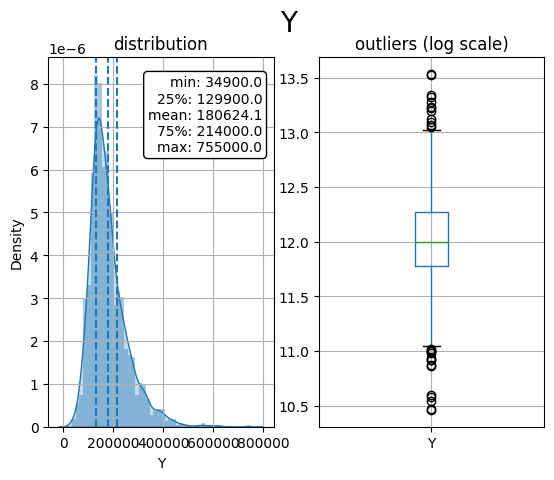

In [9]:
#From https://towardsdatascience.com/machine-learning-with-python-regression-complete-tutorial-47268e546cea
x = "Y"
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)
### distribution
ax[0].title.set_text('distribution')
variable = house_sc[x].fillna(house_sc[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable <
                    breaks[10]) ]
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = house_sc[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
### boxplot
ax[1].title.set_text('outliers (log scale)')
tmp_dtf = pd.DataFrame(house_sc[x])
tmp_dtf[x] = np.log(tmp_dtf[x])
tmp_dtf.boxplot(column=x, ax=ax[1])
plt.show()

In [10]:
np.random.seed(42)
train, test = train_test_split(house_sc, test_size = 0.5)
val, test = train_test_split(test, test_size = 0.5)
X_train = train.drop(columns = ['Y']).values
y_train = train['Y'].values
X_val = val.drop(columns = ['Y']).values
y_val = val['Y'].values
X_test = test.drop(columns = ['Y']).values
y_test = test['Y'].values
X_train.shape

(725, 195)

Random Forest

In [23]:
house_rf = RandomForestRegressor(n_estimators=500, random_state=1, criterion="absolute_error")
house_rf.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', n_estimators=500,
                      random_state=1)

In [12]:
house_rf_test_pred = house_rf.predict(X_test)

In [14]:
## Kpi
print("R2 (explained variance):", round(metrics.r2_score(y_test, house_rf_test_pred), 2))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-house_rf_test_pred)/house_rf_test_pred)), 2))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, house_rf_test_pred)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, house_rf_test_pred))))
## residuals
residuals = y_test - house_rf_test_pred
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = y_test[max_idx], house_rf_test_pred[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

R2 (explained variance): 0.79
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.1
Mean Absolute Error (Σ|y-pred|/n): 19,023
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 36,500
Max Error: -341,695


Boosting

In [19]:
house_boost = GradientBoostingRegressor(n_estimators=750, learning_rate=0.075,random_state=1, loss = "absolute_error")
house_boost.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.075, loss='absolute_error',
                          n_estimators=750, random_state=1)

In [20]:
house_boost_test_pred = house_boost.predict(X_test)

In [21]:
## Kpi
print("R2 (explained variance):", round(metrics.r2_score(y_test, house_boost_test_pred), 2))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-house_boost_test_pred)/house_boost_test_pred)), 2))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, house_boost_test_pred)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, house_boost_test_pred))))
## residuals
residuals = y_test - house_boost_test_pred
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = y_test[max_idx], house_boost_test_pred[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

R2 (explained variance): 0.78
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.09
Mean Absolute Error (Σ|y-pred|/n): 17,181
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 37,328
Max Error: -438,317
